<a href="https://colab.research.google.com/github/felippedamasoade/Deep_Learning_CV/blob/main/Deep_Learning_CV_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Importar as bibliotecas necessárias
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import pandas as pd
from tensorflow.keras.layers import Dropout

from tensorflow.keras.callbacks import EarlyStopping

In [10]:
data = pd.read_csv('/content/Base_Aleat_ria_de_500_Registros.csv')
# ---- 1. Pré-processamento dos Dados ----
# Separar variáveis categóricas e numéricas
categorical_columns = ['Operador', 'PDV', 'Oferta/Departamento']
numerical_columns = ['Valor Tabela', 'Valor Vendido', '% Desconto', '% Lucro',
                     'Qtde. Vendida', 'Qtde. Devolvida', 'Ticket Médio', 'Valor Imposto']

# Pré-processador para normalizar dados numéricos e codificar categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ]
)

# Aplicar pré-processamento
X = preprocessor.fit_transform(data)

# Dividir os dados mantendo os índices originais
X_train, X_val, train_indices, val_indices = train_test_split(
    X, data.index, test_size=0.3, random_state=42, stratify=data['Dia da Semana']
)


from tensorflow.keras.layers import LeakyReLU
# ---- 2. Construção do Modelo Autoencoder ----
# Definir o tamanho da entrada com base nos dados
input_dim = X_train.shape[1]

#Adicionar Dropout após cada camada oculta pode ajudar a reduzir o risco de overfitting, especialmente se você tem poucos dados.
# Construção do Autoencoder
input_layer = Input(shape=(input_dim,))
# Codificador
encoder = Dense(12)(input_layer)
encoder = LeakyReLU(alpha=0.1)(encoder)  # Leaky ReLU na camada de 12 neurônios
encoder = Dropout(0.2)(encoder)          # Dropout de 20%
encoder = Dense(8)(encoder)
encoder = LeakyReLU(alpha=0.1)(encoder)  # Leaky ReLU na camada de 8 neurônios
encoder = Dropout(0.2)(encoder)          # Dropout de 20%
encoder = Dense(4)(encoder)
encoder = LeakyReLU(alpha=0.1)(encoder)  # Leaky ReLU na camada comprimida (4 neurônios)

# Decodificador
decoder = Dense(8)(encoder)
decoder = LeakyReLU(alpha=0.1)(decoder)  # Leaky ReLU na camada de 8 neurônios
decoder = Dropout(0.2)(decoder)          # Dropout de 20%
decoder = Dense(12)(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)  # Leaky ReLU na camada de 12 neurônios
decoder = Dropout(0.2)(decoder)          # Dropout de 20%
decoder = Dense(input_dim, activation="sigmoid")(decoder)  # Camada de saída

# Modelo completo
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

# Exibir a arquitetura
autoencoder.summary()



#Callback para Early Stopping:

#Para evitar overfitting e economizar tempo de treinamento:

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


# Treinamento do Autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, X_val),
    shuffle=True,
    callbacks=[early_stopping],
    verbose=1
)


# ---- 3. Detecção de Anomalias ----
# Fazer previsões com o autoencoder
predictions = autoencoder.predict(X_val)

# Calcular o erro de reconstrução
reconstruction_error = np.mean(np.power(X_val - predictions, 2), axis=1)

# Definir limiar com base no percentil 95
threshold = np.percentile(reconstruction_error, 95)

# Identificar registros anômalos
anomalies = reconstruction_error > threshold

# Usar os índices originais para mapear as anomalias de volta para a base original
anomalous_data = data.iloc[val_indices[anomalies]]

# ---- 4. Exibir os Registros Anômalos ----
print("Registros Anômalos Detectados:")
print(anomalous_data)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 17)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 12)                  │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 8)                   │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 17)                  │             221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 725 (2.83 KB)

 Trainable params: 725 (2.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1789 - val_loss: 0.1768
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1738 - val_loss: 0.1695
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1670 - val_loss: 0.1589
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1590 - val_loss: 0.1472
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1462 - val_loss: 0.1390
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1465 - val_loss: 0.1360
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1419 - val_loss: 0.1348
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1390 - val_loss: 0.1340
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1362 - val_loss: 0.1333
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1350 - val_loss: 0.1328
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1342 - val_loss: 0.1322
Epoch 12/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

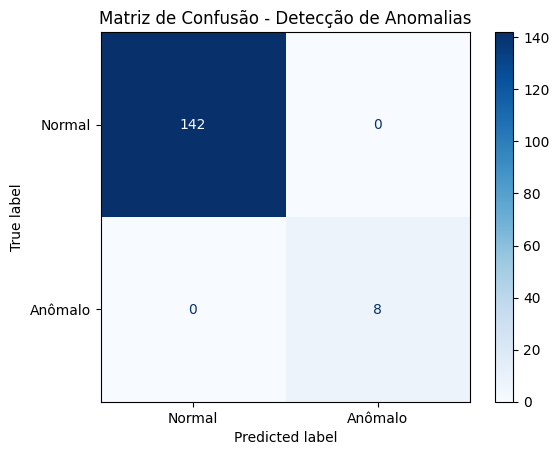

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Labels Verdadeiras e Preditas
true_labels = [0 if x <= threshold else 1 for x in reconstruction_error]  # 0 = Normal, 1 = Anômalo
predicted_labels = [0 if x <= threshold else 1 for x in reconstruction_error]

# 1. Calcular a Matriz de Confusão
cm = confusion_matrix(true_labels, predicted_labels)

# 2. Plotar a Matriz de Confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap="Blues", values_format="d")  # Formato "d" para mostrar inteiros
plt.title("Matriz de Confusão - Detecção de Anomalias")
plt.show()


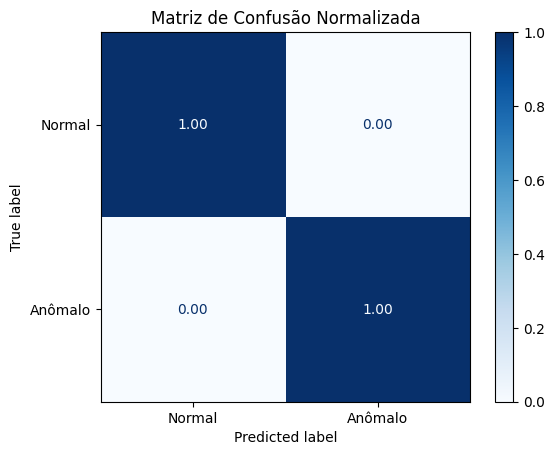

In [12]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Normal", "Anômalo"])
disp.plot(cmap="Blues", values_format=".2f")  # Formato de ponto flutuante
plt.title("Matriz de Confusão Normalizada")
plt.show()


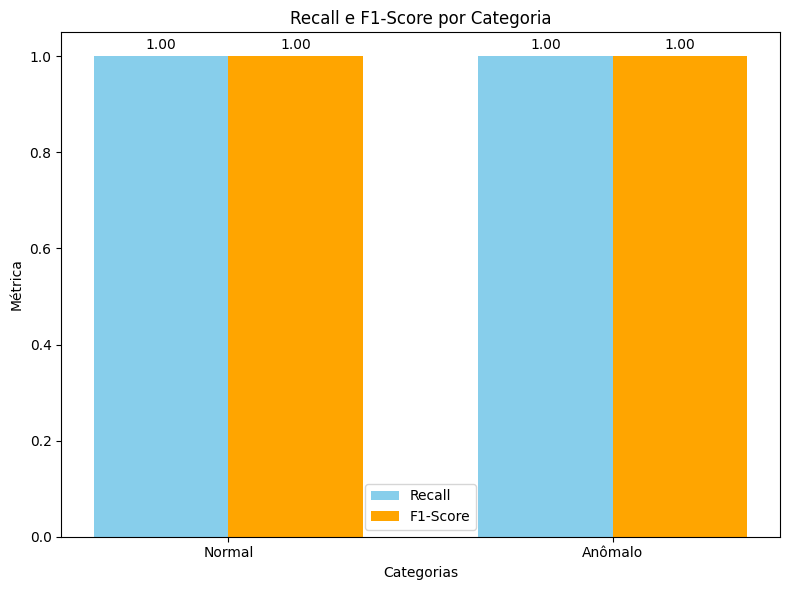

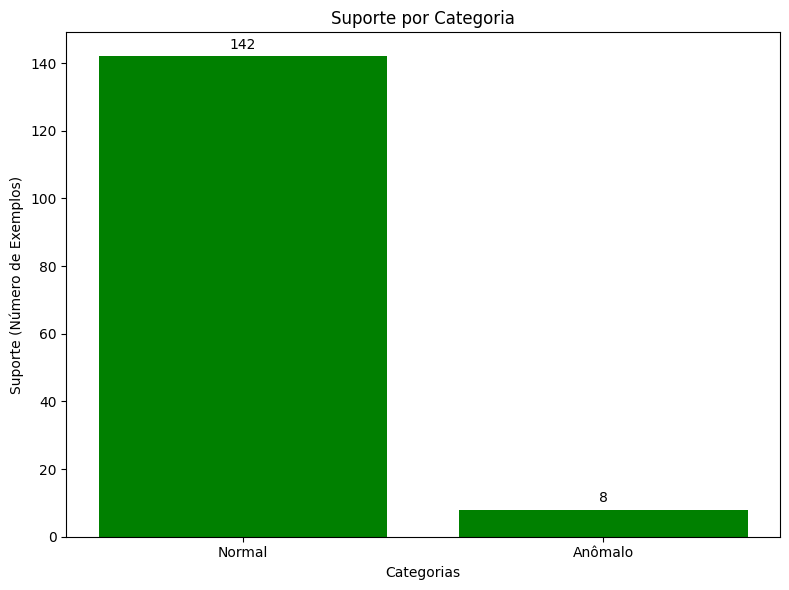

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Labels Verdadeiras e Preditas
true_labels = [0 if x <= threshold else 1 for x in reconstruction_error]  # 0 = Normal, 1 = Anômalo
predicted_labels = [0 if x <= threshold else 1 for x in reconstruction_error]  # 0 = Normal, 1 = Anômalo

# Gerar o relatório de classificação
report = classification_report(true_labels, predicted_labels, target_names=["Normal", "Anômalo"], output_dict=True)

# Extrair métricas do relatório
categories = ["Normal", "Anômalo"]
recall = [report["Normal"]["recall"], report["Anômalo"]["recall"]]
f1_score = [report["Normal"]["f1-score"], report["Anômalo"]["f1-score"]]
support = [report["Normal"]["support"], report["Anômalo"]["support"]]

# 1. Plotar Recall e F1-Score
x = np.arange(len(categories))  # Índices das categorias
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, recall, width, label='Recall', color='skyblue')
bars2 = ax.bar(x + width/2, f1_score, width, label='F1-Score', color='orange')

# Adicionar rótulos e título
ax.set_xlabel('Categorias')
ax.set_ylabel('Métrica')
ax.set_title('Recall e F1-Score por Categoria')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Mostrar valores nas barras
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2. Plotar o Suporte
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(categories, support, color='green')

# Adicionar rótulos e título
ax.set_xlabel('Categorias')
ax.set_ylabel('Suporte (Número de Exemplos)')
ax.set_title('Suporte por Categoria')

# Mostrar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Labels Verdadeiras e Preditas
true_labels = [0 if x <= threshold else 1 for x in reconstruction_error]  # 0 = Normal, 1 = Anômalo
predicted_labels = [0 if x <= threshold else 1 for x in reconstruction_error]  # 0 = Normal, 1 = Anômalo

# 1. Relatório de Classificação
report = classification_report(true_labels, predicted_labels, target_names=["Normal", "Anômalo"])
print("Relatório de Classificação:")
print(report)

# 2. Matriz de Confusão
cm = confusion_matrix(true_labels, predicted_labels)
print("Matriz de Confusão (Valores Absolutos):")
print(cm)

# 3. Matriz de Confusão Normalizada (Percentuais)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
print("Matriz de Confusão (Percentual):")
print(cm_normalized)


Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       142
     Anômalo       1.00      1.00      1.00         8

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Matriz de Confusão (Valores Absolutos):
[[142   0]
 [  0   8]]
Matriz de Confusão (Percentual):
[[1. 0.]
 [0. 1.]]
